In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from daymetpy import daymet_timeseries
from tqdm import tqdm
from scipy import stats

In [303]:
Tucson_lat = (32.440, 31.222238)
Tucson_lon = (-110.407002, -111.263)

Missoula_lat = (46.939, 45.981)
Missoula_lon = (-112.492, -114.049)

Laramie_lat = (41.4, 41.3)
Laramie_lon = (-105.5, -105.6)


In [304]:
def get_dowy(ts):
    """convert a timestamp to water year and day of water year. Return wy, dowy"""
    ts = pd.to_datetime(ts) + pd.Timedelta('92D')
    dowy = ts.dayofyear
    wy = ts.year
    return wy, dowy

def get_P_over_area(N, S, E, W):
    iterlat, iterlon = np.linspace(N, S, 30), np.linspace(E, W, 30)
    dfs = [0]*iterlat.shape[0]*iterlon.shape[0]
    j = 0
    for ilat in tqdm(iterlat):
        for ilon in iterlon:
            df = (
                daymet_timeseries(lat=ilat,lon=ilon, start_year=2019, end_year=2020)
                # .loc[:, ['year', 'prcp']]
            )

            df['lat'] = ilat
            df['lon'] = ilon
            df['WY'], df['DOWY'] = get_dowy(df.index)

            df = df.loc[df.WY == 2020]
            # df = df.set_index('DOWY')
            df = df.drop(columns='year')
            dfs[j] = df
            j += 1
    P = pd.concat(dfs)

    return P



In [305]:
P_tucson = get_P_over_area(*Tucson_lat, *Tucson_lon)
P_missoula = get_P_over_area(*Missoula_lat, *Missoula_lon)
# P_laramie = get_P_over_area(*Laramie_lat, *Laramie_lon)

100%|██████████| 30/30 [10:24<00:00, 20.83s/it]


In [306]:
# watershed areas
A_upper_clark_fork = 1_200_001.78*4046.86*(1e3)**2  # ac -> mm2
A_blackfoot = 1_480_179.81*4046.86*(1e3)**2  # ac -> mm2
A_rillito = 589_332.15*4046.86*(1e3)**2  # ac -> mm2
A_upper_santa_cruz = 1_680_515.46*4046.86*(1e3)**2  # ac -> mm2

renaming_dict = {'5614_00060_00003':'Q'}
Q_tucson = (
    pd.read_csv('santa_cruz.txt', skiprows=list(range(27)) + [28], delimiter='\t', parse_dates=['datetime'])
    .rename(columns=renaming_dict)
    .set_index('datetime')
    .loc[:, ['Q']]
)
_, Q_tucson['DOWY'] = get_dowy(Q_tucson.index)
Q_tucson = Q_tucson.set_index('DOWY')
Q_tucson['Q'] *= 0.0283168*86400*(1e3)**3  # ft3/s --> mm3/d
Q_tucson['Q'] *= 1/(A_rillito + A_upper_santa_cruz)  # scale by area to get mm/d

renaming_dict = {'81964_00060_00003':'Q'}
Q_missoula = (
    pd.read_csv('clark_fork.txt', skiprows=list(range(38)) + [39], delimiter='\t', parse_dates=['datetime'])
    .rename(columns=renaming_dict)
    .set_index('datetime')
    .loc[:, ['Q']]
)
_, Q_missoula['DOWY'] = get_dowy(Q_missoula.index)
Q_missoula = Q_missoula.set_index('DOWY')
Q_missoula['Q'] *= 0.0283168*86400*(1e3)**3  # ft3/s --> mm3/d
Q_missoula['Q']*= 1/(A_upper_clark_fork + A_blackfoot)  # scale by area to get mm/d

In [307]:
P_missoula_sem = P_missoula.groupby(['lat', 'lon']).sum()['prcp'].sem()
P_missoula_mean = P_missoula.groupby(['lat', 'lon']).sum()['prcp'].mean()
P_missoula_high = P_missoula_mean + P_missoula_sem
P_missoula_low = P_missoula_mean - P_missoula_sem

P_tucson_sem = P_tucson.groupby(['lat', 'lon']).sum()['prcp'].sem()
P_tucson_mean = P_tucson.groupby(['lat', 'lon']).sum()['prcp'].mean()
P_tucson_high = P_tucson_mean + P_tucson_sem
P_tucson_low = P_tucson_mean - P_tucson_sem


array([[<AxesSubplot: title={'center': 'prcp'}>]], dtype=object)

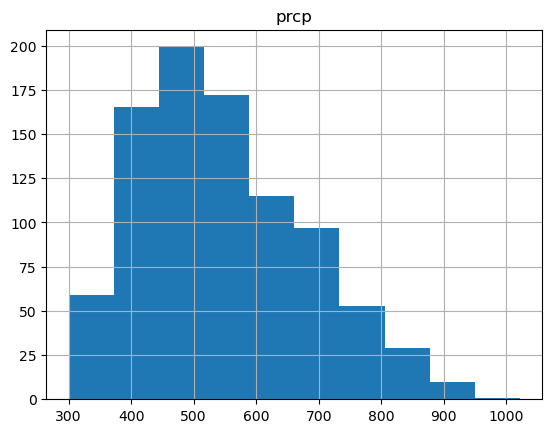

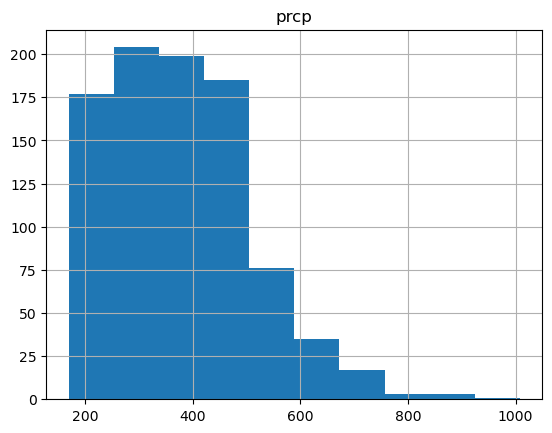

In [308]:
P_missoula.groupby(['lat', 'lon']).sum()[['prcp']].hist()
P_tucson.groupby(['lat', 'lon']).sum()[['prcp']].hist()

In [309]:
P_tucson_mean, P_tucson_sem

(379.0873777777778, 4.3332441349325554)

In [310]:
P_missoula_mean, P_missoula_sem

(547.3434777777778, 4.406366071803108)

In [311]:
Q_tucson.sum()

Q    1.695823
dtype: float64

In [312]:
Q_missoula.sum()

Q    299.679261
dtype: float64

In [313]:
P_tucson_mean - Q_tucson.sum(), P_tucson_sem

(Q    377.391554
 dtype: float64,
 4.3332441349325554)

In [314]:
P_missoula_mean - Q_missoula.sum(), P_missoula_sem

(Q    247.664217
 dtype: float64,
 4.406366071803108)

In [315]:
Balance_missoula = P_missoula.groupby('DOWY').mean()[['prcp']].merge(Q_missoula, left_index=True, right_index=True).rename(columns=dict(prcp='P'))
P_missoula_high = Balance_missoula['P'].sum() - Balance_missoula['Q'].sum()

Balance_missoula

,P,Q
DOWY,,
1,0.000000,0.439856
2,0.085789,0.437600
3,0.280522,0.435344
4,0.393222,0.430833
5,0.991522,0.426322
...,...,...
362,3.508644,0.363163
363,0.889189,0.376697
364,0.000000,0.383464


In [318]:
import xarray as xr

In [ ]:
P_tucson.

Text(0, 0.5, 'mm')

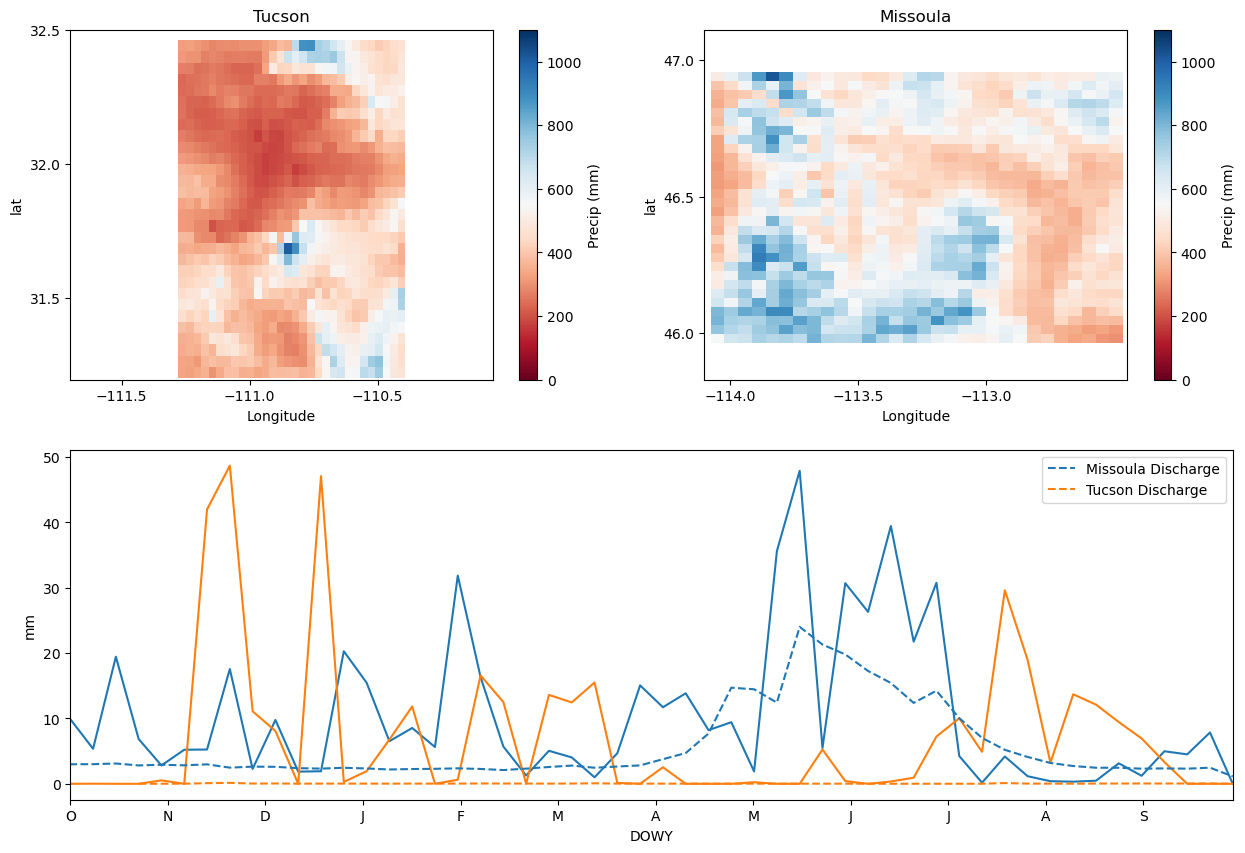

In [396]:
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(221)
xr.Dataset.from_dataframe(P_tucson.set_index(['lat', 'lon', 'DOWY'])).sum('DOWY')['prcp'].plot(vmin=0, vmax=1100, cmap='RdBu', cbar_kwargs=dict(label='Precip (mm)'))
plt.xlim(-111.7, -111.7+1.65)
plt.ylim(31.195, 31.195+1.28)
plt.xticks(np.arange(-111.5, -110, 0.5))
plt.yticks(np.arange(31.5, 33, 0.5))
plt.xlabel('Latitude')
plt.xlabel('Longitude')
plt.title('Tucson')

ax = fig.add_subplot(222)
xr.Dataset.from_dataframe(P_missoula.set_index(['lat', 'lon', 'DOWY'])).sum('DOWY')['prcp'].plot(vmin=0, vmax=1100, cmap='RdBu', cbar_kwargs=dict(label='Precip (mm)'))
plt.title('Missoula')
plt.xlim(-114.1, -114.1+1.65)
plt.ylim(45.83, 45.83+1.28)
plt.yticks(np.arange(46, 47.5, 0.5))
plt.xticks(np.arange(-114, -112.5, 0.5))
plt.xlabel('Latitude')
plt.xlabel('Longitude')
# plt.colorbar(label='Total Precip (mm)')

ax = fig.add_subplot(212)
(P_missoula.groupby(P_missoula.DOWY//7).mean()['prcp']*7).plot(y='prcp', x='DOWY', ax=ax, label='Missoula Precip', color='C0', alpha=1)
(P_tucson.groupby(P_tucson.DOWY//7).mean()['prcp']*7).plot(y='prcp', x='DOWY', ax=ax, label='Tucson Precip', color='C1')
Q_missoula.reset_index().groupby(Q_missoula.index//7).sum().plot(y='Q', label='Missoula Discharge', color='C0', linestyle='--', ax=ax)
Q_tucson.reset_index().groupby(Q_tucson.index//7).sum().plot(y='Q', label='Tucson Discharge', color='C1', linestyle='--', ax=ax)

plt.xticks(np.arange(1, 52, 4.28), list('ONDJFMAMJJAS'))
plt.xlim(1, 52)

# plt.yscale('log')
# plt.ylim(1e-2, 1e3)
# plt.xlim(2, 366)
plt.ylabel('mm')

In [300]:
30/7

4.285714285714286

In [301]:
np.arange(1, 52, 4.28).shape

(12,)

In [281]:
Q_missoula.reset_index().groupby(Q_missoula.index//30).sum()

,DOWY,Q
DOWY,,
0,435,12.561825
1,1335,12.232497
2,2235,10.554279
3,3135,9.904646
4,4035,9.688102
5,4935,11.088873
6,5835,19.734855
7,6735,71.678418
8,7635,75.348392


In [260]:
Q_missoula.reset_index()

,DOWY,Q
0,1,0.439856
1,2,0.437600
2,3,0.435344
3,4,0.430833
4,5,0.426322
...,...,...
361,362,0.363163
362,363,0.376697
363,364,0.383464
364,365,0.378953


In [253]:
Q_missoula

,Q
DOWY,
1,0.439856
2,0.437600
3,0.435344
4,0.430833
5,0.426322
...,...
362,0.363163
363,0.376697
364,0.383464
